In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
from collections import deque
import math
import random

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Implementing the NFQ algorithm
I've chosen the mountain car environment to try out the NFQ-algorithm
Some learning highlights:
* Hint-to-goal heuristic seems crucial for the success
* Make sure to have cost & min Q / reward max Q in all places.
* The number of episodes + increment fed to the training process in each batch seems to hav a large impact
* Continuing/stopping the training at the right time point is crucial. I've achieved good results with this implementation, but then ruined a good trained NFQ agent

In [4]:
import gym
# Set up environment and do a test run
env = gym.make('CartPole-v0')

In [5]:
env.observation_space


Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [6]:
if False:
    env.reset()
    n_transitions = 200

    for i in range(n_transitions):
        state, reward, done, _ = env.step(env.action_space.sample())
        env.render()
        if done:
            env.reset()

In [7]:

class NFQLearningAgent():
    def __init__(self,env,discount_factor, epsilon, nfq_net):
        self.env = env
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.nfq_net = nfq_net
        self.x_success_range = 2.4
        self.theta_success_range = 8 * 2 * math.pi / 360
        
        self.x_threshold = 2.4
        self.theta_threshold_radians = 12/180*math.pi
   
    def run_one_episode(self, explore=True):
        episode = []
        done = False
        total_cost = 0
        state = self.env.reset()
        
        for _ in range(500):
            # get best action from the NFQ net
            q_s = self.nfq_net.get_qs(state)
            self.epsilon = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            if not explore:
                action = np.argmin(q_s) 
            elif random.random() > self.epsilon:
                action = np.argmin(q_s)
            else:
                action = random.randint(0,1)
            new_state, reward, done, info = self.env.step(action) 
            # Convert rewards to cost in the interval (0.0, 1,0)
            x = new_state[0]
            theta = new_state[2]
            cost = 0.01
            if (x< -self.x_threshold or x > self.x_threshold
                or theta < -self.theta_threshold_radians
                or theta > self.theta_threshold_radians):
                #done = True
                cost = 1
            # Goal States (S+)
            elif (-self.x_success_range < x < self.x_success_range
                  and -self.theta_success_range < theta < self.theta_success_range):
                #done = False
                cost = 0
            
            
            episode.append((state, action, cost, new_state, done, info))
            # Update state
            state = new_state

            total_cost += cost
            if done:
                break
            #if 'TimeLimit.truncated' in info:
            #    #print(info)
            #    break
            
        return episode, total_cost
    
    def generate_experiences(self, n_episodes):
        experiences=[]
        for _ in range(n_episodes):
            episode, _ = self.run_one_episode()
            experiences.extend(episode)
        return experiences
    
    def get_goal_experience(self, size):
        # Hint-to-goal heuristic with values extracted from env
        goal_experiences = []
        
        for i in range(size):
            goal_experiences.append(np.array([np.random.uniform(-0.1, 0.1), 
                                              np.random.normal(), 
                                              np.random.uniform(-self.theta_success_range, self.theta_success_range), 
                                              np.random.normal(), 
                                              np.random.randint(2)]))
        goal_targets = np.zeros(size, dtype = np.float32)
        return np.array(goal_experiences), goal_targets
                            

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Copying the neural network from Riedmiller 2005
        self.MLP = nn.Sequential(
            nn.Linear(5, 5),
            nn.Sigmoid(),
            nn.Linear(5, 5),
            nn.Sigmoid(),
            nn.Linear(5, 5),
            nn.Sigmoid(),
            nn.Linear(5, 1),
        )
          # Initialize weights to [-0.5, 0.5]
        def init_weights(m):
            if type(m) == nn.Linear:
                torch.nn.init.uniform_(m.weight, -0.5, 0.5)
              
        self.MLP.apply(init_weights)

    def forward(self, x):
        
        logits = self.MLP(x.float().to(device))
        return logits
    
    def get_qs(self, state):
        qs = np.array([self.MLP(torch.cat([torch.FloatTensor(state).to(device), 
                                           torch.FloatTensor([i]).to(device)], 
                                          dim=0)).cpu().detach().numpy() for i in range(2)]).flatten()
        return qs

In [9]:
def generate_pattern_set(experiences, model, discount_factor, device):
    state_b, action_b, cost_b, next_state_b, done_b,_ = zip(*experiences)
    done_b = np.array([float(done) for done in done_b])
    state_b = torch.tensor(np.array(state_b), device=device, dtype=torch.float)
    action_b = torch.tensor(np.array(action_b), device=device, dtype=torch.float)
    cost_b = torch.tensor(np.array(cost_b), device=device, dtype=torch.float)
    next_state_b = torch.tensor(np.array(next_state_b), device=device, dtype=torch.float)
    done_b = torch.tensor(done_b, device=device, dtype=torch.float)

    # Create the input_l = sl, ul
    state_action_b = torch.cat([state_b, action_b.unsqueeze(1)], 1)

    # Compute minb Qk(sl, b)
    q_next_state_0_b = model(torch.cat([next_state_b, torch.zeros(len(experiences), 1, device=device, dtype=torch.float)], 1)).squeeze()
    q_next_state_1_b = model(torch.cat([next_state_b, torch.ones(len(experiences), 1, device=device, dtype=torch.float)], 1)).squeeze()
    q_next_state_b,_ = torch.min(torch.stack([q_next_state_0_b, q_next_state_1_b]),dim=0)
    
    # Create the target_l = c(sl, ul, sl) +γ minb Qk(sl, b)
    with torch.no_grad():
        target_q_values = cost_b + discount_factor * q_next_state_b * (1-done_b)

    return state_action_b, target_q_values

def train_loop(agent, loss_fn, optimizer, discount_factor, device):
    global steps_done
    losses=[]
    test_episode_lengths =[]
    N_batches = 100000
    state_actions = torch.empty(0,5).to(device)
    target_q_values = torch.empty(0).to(device)
    
    #Incrementally add one episode + 100 hint-to-goal heuristics for each batch
    for i_batch in range(N_batches):
        # Generating experiences
        experiences = agent.generate_experiences(1)
        # Extract and format state_actions and targets       
        state_actions_1, target_q_values_1 = generate_pattern_set(experiences, 
                                                                  agent.nfq_net, 
                                                                  discount_factor,
                                                                  device)
        state_actions = torch.cat([state_actions, state_actions_1], dim=0)
        target_q_values = torch.cat([target_q_values, target_q_values_1], dim=0)

        # Add hint-to-goal heuristics with a factor of 100
        goal_state_action_b, goal_target_q_values = agent.get_goal_experience(100)

        goal_state_action_b = torch.tensor(goal_state_action_b, device=device, dtype=torch.float)
        goal_target_q_values = torch.tensor(goal_target_q_values, device=device, dtype=torch.float)
        
        state_actions = torch.cat([state_actions, goal_state_action_b], dim=0)
        target_q_values = torch.cat([target_q_values, goal_target_q_values], dim=0)
            
        # Compute prediction and loss
        pred = model(state_actions).squeeze()
        
        loss = loss_fn(pred, target_q_values)
        losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i_batch%500 == 0:
            success_rate, ep_length = test_loop(agent, 100)
            if (success_rate >= 99.0):
                break
            scheduler.step()
            test_episode_lengths.append(ep_length)
            
        steps_done += 1

    return losses, test_episode_lengths


def test_loop(agent, n_trials):
    success = 0.
    episode_lengths=[]
    for i in range (n_trials):
        episode, total_cost = agent.run_one_episode(explore=False)
        done = episode[-1][-2]
        info = episode[-1][-1]
        episode_lengths.append(len(episode))
        if done and ('TimeLimit.truncated' in info and info['TimeLimit.truncated']):
            success+=1.
        
    success /= n_trials
    print(f"Test run, average length: {(np.mean(episode_lengths)):>0.1f}, max: {(np.max(episode_lengths)):>0.1f}")
    print(f"Success rate: {(100*success):>0.1f}%")
    return success*100, episode_lengths

In [10]:
model = NeuralNetwork().to(device)
gamma = 0.95
epsilon = 0.001


steps_done=0
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

loss_fn=nn.MSELoss()
optimizer = torch.optim.Rprop(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

NFQagent = NFQLearningAgent(env,gamma, epsilon, model)

In [11]:
losses=[]
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    losses.extend(train_loop(NFQagent, loss_fn, optimizer, gamma, device))
    success_rate, ep_length = test_loop(NFQagent, 100)
    if (success_rate >= 99.0):
        break
print("Done!")

Epoch 1
-------------------------------
Test run, average length: 9.4, max: 11.0
Success rate: 0.0%
Test run, average length: 14.7, max: 34.0
Success rate: 0.0%
Test run, average length: 141.0, max: 200.0
Success rate: 18.0%
Test run, average length: 25.1, max: 86.0
Success rate: 0.0%
Test run, average length: 37.2, max: 107.0
Success rate: 0.0%
Test run, average length: 77.3, max: 200.0
Success rate: 10.0%
Test run, average length: 54.5, max: 198.0
Success rate: 0.0%
Test run, average length: 74.8, max: 194.0
Success rate: 0.0%
Test run, average length: 69.0, max: 143.0
Success rate: 0.0%
Test run, average length: 110.0, max: 200.0
Success rate: 1.0%
Test run, average length: 177.5, max: 200.0
Success rate: 38.0%
Test run, average length: 199.2, max: 200.0
Success rate: 99.0%
Test run, average length: 199.2, max: 200.0
Success rate: 99.0%


TypeError: '>=' not supported between instances of 'tuple' and 'float'

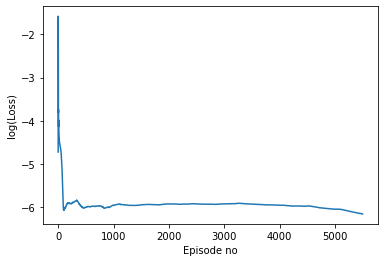

In [16]:
plt.figure()
plt.plot(np.log(losses[0]))
yl=plt.ylabel('log(Loss)')
yl=plt.xlabel('Episode no')

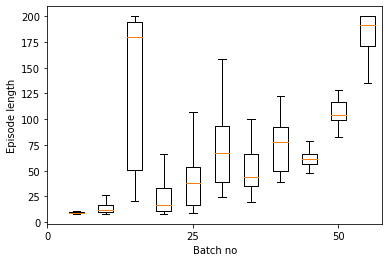

In [15]:
plt.figure()
p=plt.boxplot(losses[1], showfliers=False)#[np.mean(ep) for ep in losses[1]])
n_batches = len(losses[1])
t=plt.xticks(ticks=np.arange(0,n_batches,5), labels=5*np.arange(0,n_batches,5))
yl=plt.ylabel('Episode length')
yl=plt.xlabel('Batch no')

In [14]:
len(losses[0])

5501

In [ ]:
# Do a test run using the trained NFQ agent
test_loop(NFQagent, 500)

In [18]:
# For visualization
state = env.reset()
n_transitions = 1000

for i in range(n_transitions):
    q_s = NFQagent.nfq_net.get_qs(state)
    action = np.argmin(q_s)
    #print(action, q_s)
    state, reward, done, info = env.step(action)
    
    env.render()
    if done:
        if 'TimeLimit.truncated' in info:
            print(info)
        else:
            print('Terminated: Failed')
        env.reset()

{'TimeLimit.truncated': True}
{'TimeLimit.truncated': True}
{'TimeLimit.truncated': True}
{'TimeLimit.truncated': True}
{'TimeLimit.truncated': True}
